# Generate 
# pruned_argoverse_T0X_9000X_vector_map.xml 


In [2]:
import pandas as pd
from ast import literal_eval
import numpy as np
import pickle
import xml.etree.ElementTree as ET
import xml.dom.minidom
import pdb

wp_root = 'wp_dicts/'
xodr_root = 'xodr_files/'
cargomap_root = 'cargomap/'

available_maps = ['Town01', 'Town02', 'Town03', 'Town04', 'Town05']
converters = {'idx':int, 'id':int, 'road_id':int, 'lane_id':int, 'loc':literal_eval, 
             'is_junction':bool}
for map_name in available_maps:
    
    # load wp_dict
    csv_fname = wp_root + 'wp_dict_' + map_name + '.csv'
    wp_df = pd.read_csv(csv_fname, converters=converters)
    wp_df = wp_df.rename(columns={'Unnamed: 0': 'idx'}) # It has only 'driving' type wp

    wp_dict = wp_df.to_dict()
    wp_len = len(wp_dict['idx'])
    
    # load light_xodr 
    fname = xodr_root + map_name+'_light_pretty.xodr'
    with open(fname) as fi:
        xml_tree = ET.parse(fi)
    root = xml_tree.getroot()
    
    # Generate node_list
    node_list = []
    for i in range(wp_len):
        wpd = {'id': str(wp_dict['idx'][i]), 'x':str(wp_dict['loc'][i][0]), 'y':str(wp_dict['loc'][i][1])} 
        node_list.append(wpd)
        
    # Generate way_list
    # step 01 : find ref nodes

    # Key: 'road_id' + '_' + 'lane_id' 
    # Value: [idx0, idx1, ...]

    lane_segments = {}
    for i in range(wp_len):
        key = str(wp_dict['road_id'][i]) + '_' + str(wp_dict['lane_id'][i])
        if key in lane_segments.keys():
            lane_segments[key].append(wp_dict['idx'][i])
        else:
            lane_segments[key] = [wp_dict['idx'][i]]
    
    # way step 02 : find next, previous key

    # Key: 'road_id' + '_' + 'lane_id' 
    # Value: {'node': [idx0, idx1, ...], 'next_key': next road id, 'previous_key': previous road id

    lane_segments_np = {}
    for i, (k, v) in enumerate(lane_segments.items()):

        road_id, lane_id = k.split('_')
        for x_child in root:
            if x_child.tag == "road" and x_child.attrib['id'] == road_id:


                for z_child in x_child:
                    if z_child.tag == "predecessor":
                        pre_type = z_child.attrib['elementType']
                        pre_id = z_child.attrib['elementId']
                        pre_from = eval(z_child.attrib['lane_id_from'])
                        pre_to = eval(z_child.attrib['lane_id_to'])

                    elif z_child.tag == "successor":
                        suc_type = z_child.attrib['elementType']
                        suc_id = z_child.attrib['elementId']
                        suc_from = eval(z_child.attrib['lane_id_from'])
                        suc_to = eval(z_child.attrib['lane_id_to'])
                break
    #     if i == 73:
    #         pdb.set_trace()
        nk = []
        if suc_type == 'road':
            suc_road_id = suc_id
            try:
                suc_lane_id = suc_to[suc_from.index(lane_id)]
                nk.append(suc_road_id + '_' + suc_lane_id)
            except Exception as e:
                print(e) ## Bug?
        elif suc_type == 'junction':
            for x_child in root:
                if x_child.tag == "junction" and x_child.attrib['id'] == suc_id:
                    for y_child in x_child:
                        if y_child.tag == "connection" and y_child.attrib['incomingRoad'] == road_id:
                            for z_child in y_child:
                                if z_child.tag == 'laneLink' and z_child.attrib['from'] == lane_id:
                                    suc_road_id = y_child.attrib['connectingRoad']
                                    suc_lane_id = z_child.attrib['to']
                                    nk.append(suc_road_id + '_' + suc_lane_id)


        pk = []
        if pre_type == 'road':
            pre_road_id = pre_id
            pre_lane_id = pre_to[pre_from.index(lane_id)]
            pk.append(pre_road_id + '_' + pre_lane_id)
        elif pre_type == 'junction':
            for x_child in root:
                if x_child.tag == "junction" and x_child.attrib['id'] == pre_id:
                    for y_child in x_child:
                        if y_child.tag == "connection" and y_child.attrib['incomingRoad'] == road_id:
                            for z_child in y_child:
                                if z_child.tag == 'laneLink' and z_child.attrib['from'] == lane_id:
                                    pre_road_id = y_child.attrib['connectingRoad']
                                    pre_lane_id = z_child.attrib['to']
                                    pk.append(pre_road_id + '_' + pre_lane_id)

        key = k    
        value = {}
        value['node'] = v
        value['next_key'] = nk
        value['previous_key'] = pk
        lane_segments_np[key] = value

    
    # way step 03 : find left right neighbor, is_intersection

    way_len = len(lane_segments_np.keys())
    curr_id = 900000 + int(map_name[-2:]) * 10000

    way_list = []
    for k, v in lane_segments_np.items():
        curr_id = curr_id + 1
        ## lane_id: argoverse way identifier, lane: OpenDrive lane identifier
        road, lane = k.split('_')
        nodes = v['node']
        nk = v['next_key']
        pk = v['previous_key']
        if int(lane) > 0:
            rnk = road + '_' + str(int(lane)+1)
            lnk = road + '_' + str(int(lane)-1)
        else:
            rnk = road + '_' + str(int(lane)-1)
            lnk = road + '_' + str(int(lane)+1)

        if rnk in lane_segments_np.keys():
            right_neighbor_key = rnk
        else:
            right_neighbor_key = None

        if lnk in lane_segments_np.keys():
            left_neighbor_key = lnk
        else:
            left_neighbor_key = None

        is_intersection = wp_dict['is_junction'][nodes[0]]

        way_dict = {'curr_id':curr_id, 'lane_key':k, 'nodes':nodes, 'next_key':nk, 'previous_key':pk,
                'right_neighbor_key':right_neighbor_key, 'left_neighbor_key':left_neighbor_key,
                'is_intersection':is_intersection}
        way_list.append(way_dict)
    
    # way step 04 : replace from_keys to to_keys
    
    curr_id_list = []
    lane_key_list =[]
    for wd in way_list:
        curr_id_list.append(wd['curr_id'])
        lane_key_list.append(wd['lane_key'])
    
    from_keys = ['right_neighbor_key', 'left_neighbor_key']
    to_keys = ['r_neighbor_id', 'l_neighbor_id']

    for way_dict in way_list:
        for from_key, to_key in zip(from_keys, to_keys):
            if way_dict[from_key] in lane_key_list:
                idx = lane_key_list.index(way_dict[from_key])
                way_dict[to_key] = curr_id_list[idx]
            else:
                way_dict[to_key] = None

    for way_dict in way_list:
        for from_key in from_keys:
            del way_dict[from_key]
            
    from_keys = ['next_key', 'previous_key']
    to_keys = ['successor', 'predecessor']

    for way_dict in way_list:
        for from_key, to_key in zip(from_keys, to_keys):
            id_list = []
            for k in way_dict[from_key]:
                if k in lane_key_list:
                    idx = lane_key_list.index(k)
                    id_list.append(curr_id_list[idx])
            way_dict[to_key] = id_list 

    # Commented for debug
    # for way_dict in way_list:
    #     for from_key in from_keys:
    #         del way_dict[from_key]
    
    # way step 05: correct lane direction
    # from: road-wise direction
    # to: lane-wise direction

    for way_dict in way_list:
        # lane direction is opposite from road direction
        if int(way_dict['lane_key'].split('_')[1]) > 0 : 
            t = way_dict['successor']
            way_dict['successor'] = way_dict['predecessor']
            way_dict['predecessor'] = t
    
    # way step 06: generate uninformed predecessor
    # (original XODR file does't provide predecessor information in junction)
    
    map_suc = {} # {suc:cur, ...} <-> {cur:pre}
    for way_dict in way_list:
        from_idx = way_dict['curr_id']
        to_idxs = way_dict['successor']

        for to_idx in to_idxs:
            if to_idx in map_suc.keys():
                map_suc[to_idx].append(from_idx)
            else:
                map_suc[to_idx] = [from_idx]

    for way_dict in way_list:
        curr_id = way_dict['curr_id']
        if curr_id in map_suc.keys():
            way_dict['predecessor'] = map_suc[curr_id]


    # generate argoverse xml map!


    city_name = "T"+map_name[-2:]
    city_id = 90000 + int(map_name[-2:])
    fname = cargomap_root + f"pruned_argoverse_{city_name}_{city_id}_vector_map.xml"

    root = ET.Element("CarlaMap")

    for node_dict in node_list:
        node = ET.SubElement(root, "node")
        node.set("id", node_dict['id'])
        node.set("x", node_dict['x'])
        node.set("y", node_dict['y'])
        
    for way_dict in way_list:
    
    #     if len(way_dict['nodes']) < 2: -> loss connectivity
    #         continue

        way = ET.SubElement(root, "way")
        way.set("lane_id", str(way_dict['curr_id']))

        tag = ET.SubElement(way, "tag")
        tag.set("k", "is_intersection")
        tag.set("v", str(way_dict['is_intersection']))

        tag = ET.SubElement(way, "tag")
        tag.set("k", "l_neighbor_id")
        tag.set("v", str(way_dict["l_neighbor_id"]))

        tag = ET.SubElement(way, "tag")
        tag.set("k", "r_neighbor_id")
        tag.set("v", str(way_dict["r_neighbor_id"]))

        for idx in way_dict['nodes']:
            nd = ET.SubElement(way, "nd")
            nd.set("ref", str(idx))

        try:
            for pre in way_dict["predecessor"]:
                tag = ET.SubElement(way, "tag")
                tag.set("k", "predecessor")
                tag.set("v", str(pre))
        except Exception as e:
            pass

        try:
            for suc in way_dict['successor']:
                tag = ET.SubElement(way, "tag")
                tag.set("k", "successor")
                tag.set("v", str(suc))
        except Exception as e:
            pass
    

    tree = ET.ElementTree(root)
    with open(fname, "wb") as files:
        tree.write(files)
    
    
    dom = xml.dom.minidom.parse(fname)
    pretty_xml_as_string = dom.toprettyxml()

    fname_pretty = cargomap_root + f"pruned_argoverse_{city_name}_{city_id}_vector_map.xml"
    with open(fname_pretty, "w") as files:
        files.write(pretty_xml_as_string)
    print(fname_pretty, 'has saved.')
    

cargomap/pruned_argoverse_T01_90001_vector_map.xml has saved.
cargomap/pruned_argoverse_T02_90002_vector_map.xml has saved.
'-5' is not in list
'-4' is not in list
cargomap/pruned_argoverse_T03_90003_vector_map.xml has saved.
cargomap/pruned_argoverse_T04_90004_vector_map.xml has saved.
cargomap/pruned_argoverse_T05_90005_vector_map.xml has saved.


In [3]:
way_list.__len__()

486

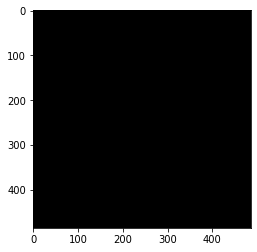

In [4]:
# pre / suc sanity check 
import matplotlib.pyplot as plt

wl = len(way_list)
heat_map = np.zeros([wl, wl])

init_idx = 900000 + int(map_name[-2:]) * 10000 +1

for i, way_dict in enumerate(way_list):
    from_idx = way_dict['curr_id']
    to_idxs = way_dict['successor']
    for to_idx in to_idxs:
        heat_map[from_idx -init_idx, to_idx -init_idx] = 1
        
    to_idxs = way_dict['predecessor']
    for to_idx in to_idxs:
        heat_map[from_idx -init_idx, to_idx -init_idx] = 1
        
    heat_map[i, i] = 1
    
diff_map = heat_map - np.transpose(heat_map)

plt.imshow(diff_map, cmap='gray')
plt.show()


In [5]:
diff_map[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
# for debug
print(way_list[67])
print(way_list[66])
# print(way_list[77])

{'curr_id': 950068, 'lane_key': '2307_-1', 'nodes': [1659, 1661, 1663, 1665, 1667, 1669, 1671, 1673, 1675, 1677, 1679, 1681, 1683, 1685, 1687, 1689, 1691, 1693, 1695, 1697, 1699, 1701, 1703, 1705, 1707, 1709], 'next_key': ['14_-1'], 'previous_key': ['13_-1'], 'is_intersection': True, 'r_neighbor_id': 950067, 'l_neighbor_id': None, 'successor': [950188], 'predecessor': [950333]}
{'curr_id': 950067, 'lane_key': '2307_-2', 'nodes': [1658, 1660, 1662, 1664, 1666, 1668, 1670, 1672, 1674, 1676, 1678, 1680, 1682, 1684, 1686, 1688, 1690, 1692, 1694, 1696, 1698, 1700, 1702, 1704, 1706, 1708], 'next_key': ['14_-2'], 'previous_key': ['13_-2'], 'is_intersection': True, 'r_neighbor_id': None, 'l_neighbor_id': 950068, 'successor': [950187], 'predecessor': [950332]}


In [7]:
# sanity check
print(len(node_list))
print(node_list[0])
print(node_list[-1])

24212
{'id': '0', 'x': '15.171202659606934', 'y': '201.64096069335938'}
{'id': '24211', 'x': '32.991817474365234', 'y': '-76.92013549804688'}


In [8]:
len(way_list)
print(way_list[136])
print(way_list[353])

{'curr_id': 950137, 'lane_key': '49_-2', 'nodes': [4029, 4033, 4037, 4041, 4045, 4049, 4053, 4057, 4061, 4065, 4069, 4073, 4077, 4081], 'next_key': ['1046_-2', '1121_-1'], 'previous_key': ['5_-2'], 'is_intersection': True, 'r_neighbor_id': None, 'l_neighbor_id': 950138, 'successor': [950386, 950476], 'predecessor': [950278]}
{'curr_id': 950354, 'lane_key': '4_-1', 'nodes': [18093, 18097, 18101, 18105, 18109, 18113, 18117, 18121, 18125, 18129, 18133, 18137, 18141, 18145, 18149, 18153, 18157, 18161, 18165, 18169, 18173, 18177, 18181, 18185, 18189], 'next_key': ['68_-1', '89_-1'], 'previous_key': [], 'is_intersection': True, 'r_neighbor_id': 950353, 'l_neighbor_id': None, 'successor': [950453, 950112], 'predecessor': [950226]}


In [ ]:
1566_1, 

In [ ]:
# junction -> neighbor X

In [17]:
int(map_name[-2:])

3

# Generate 
# T0X_9000X_tableidx_to_laneid_map.json 
# T0X_9000X_halluc_bbox_table.npy 




In [22]:
# load light_xodr 

fname = map_name+'_light_pretty.xodr'
with open(fname) as fi:
    xml_tree = ET.parse(fi)
root = xml_tree.getroot()

In [23]:
from argoverse.utils.manhattan_search import compute_point_cloud_bbox
from argoverse.utils.centerline_utils import centerline_to_polygon
import json

# map lane segment IDs to their index in the table
tableidx_to_laneid_map = {}
# array that holds xmin,ymin,xmax,ymax for each coord
halluc_bbox_table = []
table_idx_counter = 0

for way_dict in way_list:
    
    if len(way_dict['nodes']) < 2:
        print(way_dict['lane_key'], ' skipped')
        continue
    
    tableidx_to_laneid_map[table_idx_counter] = way_dict['curr_id']
    table_idx_counter += 1
    
#     root
    road_id, lane_id = way_dict['lane_key'].split('_')
    for road in root.iter('road'):
        if road.attrib['id'] == road_id:
            for lane in road.iter('lane'):
                lane_ids = eval(lane.attrib['ids'])
                lane_widths = eval(lane.attrib['widths'])
                assert len(lane_ids) == len(lane_widths)
                width = lane_widths[lane_ids.index(lane_id)]
                    
#                     
    
#     print(way_dict['lane_key'])
#     print(width)
    
    
    list_np_xy = []
    for node in way_dict['nodes']:
        x = wp_dict['loc'][node][0]
        y = wp_dict['loc'][node][1]
        list_np_xy.append(np.array([x, y]))
    try:
        poly = centerline_to_polygon(np.stack(list_np_xy), 
                                     width_scaling_factor = width/3.8, 
                                     visualize=False)
    except Exception as e:
        pdb.set_trace()
        print(e)
        print(np.stack(list_np_xy).shape)
    xmin, ymin, xmax, ymax = compute_point_cloud_bbox(poly)
    halluc_bbox_table += [(xmin, ymin, xmax, ymax)]

halluc_bbox_table = np.array(halluc_bbox_table)


81_-2  skipped
77_-1  skipped
77_1  skipped
51_-1  skipped
51_1  skipped
12_-5  skipped
12_-4  skipped
11_-5  skipped
11_-4  skipped
9_-5  skipped
9_-4  skipped
5_-2  skipped
5_-1  skipped
5_4  skipped
5_5  skipped
32_-2  skipped
32_-1  skipped
32_4  skipped
32_5  skipped
35_-5  skipped
35_-4  skipped
37_-5  skipped
37_-4  skipped
45_-2  skipped


/home/jongwon/anaconda3/envs/lanegcn/lib/python3.7/site-packages/argoverse/utils/centerline_utils.py:71: RuntimeWarning: divide by zero encountered in true_divide
  inv_slopes = -1.0 / slopes


In [24]:
np.save(
        f"{city_name}_{city_id}_halluc_bbox_table.npy",
        halluc_bbox_table,
    )
with open(f"{city_name}_{city_id}_tableidx_to_laneid_map.json", "w") as outfile:
    json.dump(tableidx_to_laneid_map, outfile)

In [248]:
## Generate validation code of above cell ##

## Skip -> Problem?



In [249]:
halluc_bbox = np.load(f"{city_name}_{city_id}_halluc_bbox_table.npy")

In [223]:
halluc_bbox.shape

(482, 4)

In [172]:
halluc_bbox[0]

array([-63.13774276, 184.71541919, -33.16697694, 195.38504011])